# note: 
please create a fresh Anaconda env:<br>
`conda create -n allensdk pip numpy=1.18.1 pandas=0.25.1 jupyterlab`<br>
`conda activate allensdk`<br>
`pip install allensdk`

and relaunch this Jupyter Lab server:<br>
`jupyter lab`<br>
before running this notebook

## or
run this cell

In [5]:
# !pip install allensdk --no-dependencies
!pip install xarray pynwb requests_toolbelt SimpleITK simplejson tqdm marshmallow argschema psycopg2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 6.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for psycopg2: filename=psycopg2-2.9.7-cp311-cp311-macosx_10_9_x86_64.whl size=133955 sha256=7ae0cac2b47f26193ff786a1ceda3d599f365b464f2c70ea10a560c9ca4cb0b0
  Stored in directory: /Users/danieljdenman/Library/Caches/pip/wheels/ca/a2/1f/9f85470e2065e7a4089baa6c47cfa57a2f8f8e78e07390c5b4
Successfully built psycopg2


# Computing Direction Tuning with Python in a Jupyter notebook
We're going to use data from [Siegle, Jia et al., bioRxiv 2019](https://www.biorxiv.org/content/10.1101/805010v1) for this notebook. This is Neuropixels data collected in several visual areas in the awake mouse brain, while the mouse is viewing visual stimuli. We'll get the data using the [Allen Software Development Kit](https://allensdk.readthedocs.io/en/latest/), which Python to programmatically access [this data](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html). There are other example Jupyter notebooks, as well as more documentation for the SDK and Neuropixels datasets at the Allen SDK Neuropixels [link](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).
<br>The goal will be to get some spikes times, some stimulus times, and plot direction tuning curves like this one on the right:. 
<br>


![Hubel and Wiesel, 1968](../res/HW68_DS.jpg)

##### Some of the code is pre-written, and you will simply execute it. In other cases, you will be prompted to write some code lines to advance towards this goal. **There are going to be 8 such prompts,** plus some bonus challenges if you want to keep going.

## Imports of packages we will need for this notebook. 
#### All are standard and those that we have talked about, plus the AllenSDK for gettting the data

In [6]:
import numpy as np
import os,sys,glob
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache, EcephysSession

### Now we will get the Neuropixels data from the Allen Institute servers. 
The details of this are not critical, and can be ignored for now in order to get the rest of this notebook. There are some useful examples of working with a pandas DataFrame, and a desription of class objects for some slightly more advanced Pythoning. You can skip to the big
# ==========================================================

below if you'd like, but you have to run these cells first. So, some Jupyter practice: press ```Shift + Enter``` to run a cell and advance to the next one

In [ ]:
data_directory = '~/' 
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()

The important result of this  is that we will end up with a pandas DataFrame with sessions (i.e., recording sessions) in it:

In [ ]:
print('Total number of sessions: ' + str(len(sessions)))
sessions.head()

Total number of sessions: 58


published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

Because this is a pandas dataframe, we can easilty search the values (for example, for genotype) and filter it (for example, for wild type C57s only, male, with a probe in primary visual cortex (VISp))

For example, what kind of genoypes are there? we can query the pandas DataFrame ```sessions``` with ```.unique()``` to find all of the genotpyes in the DataFrame:

In [ ]:
sessions.full_genotype.unique()

In [ ]:
filtered_sessions = sessions[(sessions.sex == 'M') & \
                             (sessions.full_genotype == 'wt/wt') & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

filtered_sessions.head()

for our purposes, you should choose a session that has ```session_type` =='brain_observatory_1.1'``` and ```['VISp' in acronyms for acronyms in sessions.ecephys_structure_acronyms]```. but beyond that, you could chooose any session. i'll choose the last session in my ```filtered_sessions``` DataFrame:

*note: To save time [and because the AllenSDK is flaky with Neuropixels data because of the Allen servers], i've downloaded this session already and stored it in the Google cloud such that you can access it directly. I left the AllenSDK call in this cell, but commented it out, so you can see how straightforward it **might** have been to get this data. You can also see this in the the TimeSeries_PatchClamp.ipynb, another of our Day1 options.*

In [9]:
# from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
# #AllenSDK
# session = cache.get_session_data(filtered_sessions.index.values[-1])

# start here for loading data if not using AllenSDK
downloading the data will take ~2 minutes from the denmanlab cloud storage

In [7]:
import requests
r = requests.get("https://storage.googleapis.com/denmanlab/ecephys_session_799864342.nwb", stream = True)
with open(os.path.join('..','data','ecephys_session_799864342.nwb'), "wb") as p:
    for chunk in r.iter_content(chunk_size = 1024):
        if chunk:
            p.write(chunk)
session = EcephysSession.from_nwb_path(os.path.join('..','data','ecephys_session_799864342.nwb'))

Now we have all of the data (recorded neural data, stimulus information) for one recording session. let's take a pause and assess what we have. what is the data type of ```session```?

In [ ]:
type(session)

this is a data object that is not a basic type! what is an "EcephysSession"? it's a class object defined by the AllenSDK. classes have functions (methods) of their own, and attributes. both are accessed with by putting a ```.``` after the class object. here's funky line that will tell us what all of the attributes of ```session``` object:

In [ ]:
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

In [ ]:
v1_units = session.units[session.units.ecephys_structure_acronym == 'VISp']
v1_spike_times = [session.spike_times[cell] for cell in session.units.index[session.units.ecephys_structure_acronym == 'VISp']]
v1_units['spike_times']=v1_spike_times

note: this one might take a few seconds to execute

# ==========================================================
## Now we've got data, let's get to work. Our initial goal is to determine the preferred direction of a neuron in V1. Something like the right side of this figure:

![Hubel and Wiesel, 1968](../res/HW68_DS.jpg)

To generate a plot like this, we need know 
1. the times of the spikes from each neuron, and 
2. the times of the stimuli of the various directions.
<br>


let's start with spike times. above, we got the "units" (a.k.a. "neurons") from primary visual cortex recorded and isolated in this session. Their information is in ```v1_units```. 
<br>**First question of this exercise:<br>Q1. What type of data is ```v1_units```? write some code that will give the answer in the cell below:**

**Q2. How many neurons were recorded in V1 in this recording? write some code that will give the answer in the cell below:**
_note: there is not one way to do this; there are several. any is fine!_

ok, so we have ___ neurons in V1 in this recording. Let's choose one and look at it's spike times. 
<--**if you want, put your answer to how many neurons we have in V1 here**<br>
i'll choose (semi-randomly, unit 951095552):

In [ ]:
v1_units.index

In [ ]:
chosen_neuron_spike_times = v1_units[v1_units.index==v1_units.index[8]].spike_times.values[0]
print(chosen_neuron_spike_times)

so, now we have ```chosen_neuron_spike_times```, in seconds. how do we get the oriented stimulus times? 

We'll get all of the stimulus information from the ```session``` object. The details of this ```session``` object are beyond the scope here, but the stimlus information is all in a pandas DataFrame in ```session``` so we will get it (and call in ```stimuli```):

In [ ]:
stimuli = session.stimulus_presentations
print(type(stimuli))

note: this cell may take a few seconds, be patient

what kind of stimuli were there? we can use the nice ```.unique()``` method of pandas Series (column) or DataFrame (table):

In [ ]:
stimuli.stimulus_name.unique()

we want  ```'drifting_gratings'```, which is the type of stimulus that has oriented stimuli for making an direction tuning curve. We filter all of the stimuli to get onlu the grating stimuli:

In [ ]:
grating_stimuli = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'drifting_gratings']
grating_stimuli = grating_stimuli[grating_stimuli.orientation != 'null']
print(grating_stimuli.orientation.unique()) # ignore the fact that this is called "orientation" and not "direction". can't win them all!

note, we have grating stimuli with various directions, separated by 45º. great for making an direction tuning curve! what else do we know about these grating stimuli? we'll use ```.head()``` to show us just the first five entries in ```grating_stimuli```, that way we can read all of the columns and get a flavor:

In [ ]:
grating_stimuli.head()

notice the column ```start_time```. this is the start of each grating presentation, in seconds. 
<br> so, to get the stimulus times of each grating with an direction of 0º, we filter the ```grating_stimuli``` DataFrame again, and get the ```.start_time``` column:

In [ ]:
direction_0_times = grating_stimuli.start_time[grating_stimuli.orientation==0.0].values
print(len(direction_0_times))

A grating of direction 0º was shown 75 times.<br>
**Q3: How long (in duration) was each of these 75 presentations? make a variable called ```duration``` and assign it your answer (in seconds). note that ```duration``` should be a ```float```** <br>_hint: look at the other column names in ```grating_stimuli```_

We can now answer the question: for direction X how many spikes did your chosen v1 cell fire during the stimulus presentation period (start time + duration)? We will do so by counting the spike times of our chose v1 cell that occur between ```start_time``` and ```start_time``` + ```duration```. first, i'll write this out in the most explicit way possible, with ```for``` loops and ```if``` statements. <br>For demonstration purposes, let's also time it.

In [51]:
import time

In [ ]:
start = time.time()
dir0_counts = []
for start_time in direction_0_times:
    count = 0
    for spike_time in chosen_neuron_spike_times:
        if spike_time > start_time:
            if spike_time < start_time + duration:
                count = count + 1
    dir0_counts.extend([count])
print('that took: '+str(time.time()-start)+' seconds')

the above code works, but it is pretty slow and inefficent (in terms of lines of code). using ```numpy```'s ```np.where``` function and a python concept called list comprehension, we can do this in one line, and lightning fast:

In [ ]:
start = time.time()
dir0_counts2 = [len(np.where((chosen_neuron_spike_times >= start_time) & (chosen_neuron_spike_times <=start_time+duration))[0]) for start_time in direction_0_times]
print('that took: '+str(time.time()-start)+' seconds')

note, reassuringly, that we got the same answer:

In [ ]:
dir0_counts == dir0_counts2

Let's start making our direction tuning curve:

In [ ]:
direction = np.array([0]) # in degrees
mean_spike_count = np.array([np.mean(dir0_counts)])

In [ ]:
open(os.path.join('..','data','ecephys_session_799864342.nwb'),"wb"

Welp, the plot didn't work.<br>
**Q4: why not? make the above plot work, without changing the code in the cell. add a cell above it, and then rerun the cell with ```plt.plot(direction,mean_spike_count)``` (or...if it did work...what had you done that made it work?)**

Finally, a plot! Let's finish making our direction tuning curve. We need to iterate over all of the presented directions. <br>
**Q5: What are all of the presented stimulus directions in this session? iterate over all of them, printing them in each iteration**

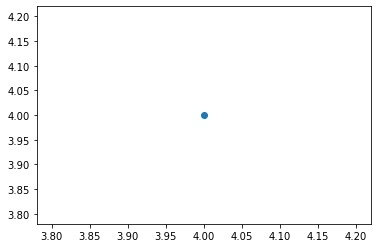

In [2]:
import matplotlib.pyplot as plt
plt.scatter(4,4)

**Q6: iterate over the stimulus directions again, but this time instead of printing them, count the number of spikes within the duration.** _hint: go back and look at how we did this for dir0_counts2_

**Q7: plot the mean spike count as a function of direction**

In [ ]:
plt.plot(??????)

**Q8: add error bars (standard deviation) to the plot from Q7. use plt.errorbar(), and note that you can measure the standard deviation of a list or array of spike counts with np.std()**<br> this may or may not take a few lines or cells to recompute the standard deviation. feel free to work below!

In [ ]:
plt.errorbar(?????)

Bonus!<br>**Convert the spike counts to firing rate (spikes / sec)**

Bonus!<br>**What is the cells's preferred orientation (the orientation with the highest mean evoked spike count?)**